In [1]:
from qumcmc.quantum_mcmc_routines import *

# checking something

In [1]:
import numpy as np

In [2]:
from qulacs import Observable, QuantumCircuit, QuantumState
from qulacs.gate import Y,CNOT,merge

In [3]:
state = QuantumState(3)
state.set_Haar_random_state()

circuit = QuantumCircuit(3)
circuit.add_X_gate(0)
merged_gate = merge(CNOT(0,1),Y(1))
circuit.add_gate(merged_gate)
circuit.add_RX_gate(1,0.5)
circuit.update_quantum_state(state)

observable = Observable(3)
observable.add_operator(2.0, "X 2 Y 1 Z 0")
observable.add_operator(-3.0, "Z 2")
value = observable.get_expectation_value(state)
print(value)

2.795731998762427


In [4]:
n = 5
state = QuantumState(n)
state.set_Haar_random_state(0)

# Get quantum bit numbers
qubit_count = state.get_qubit_count()
print("qubit_count", qubit_count)

# Get the probability that the specified qubit will be measured as 0
prob = state.get_zero_probability(1)
print("zero_prob_1", prob)

# Get arbitrary marginal probabilities
# Argument is an array of the same length as the number of qubits
# Specify 0,1,2. 0,1 is the probability of the subscript measured at that value
# 2 means that bit is peripheralized.
# For example, calculation of the probability that the third is measured as 0 and the 0th is measured as 1:
prob = state.get_marginal_probability([1,2,2,0,2])
print("marginal_prob", prob)

# Get the entropy of the probability distribution when measured on the Z basis
ent = state.get_entropy()
print("entropy", ent)

# Get squared norm (<a|a>)
# Because the operation maybe not Trace preserving, the norm of state does not necessarily to be 1.
sq_norm = state.get_squared_norm()
print("sqaured_norm", sq_norm)

# The number of measurements and sampling of all qubits Z-basis is given by the argument.
# Get a list of integers converted from the resulting binaries.
samples = state.sampling(10)
print("sampling", samples)

# Get a character string indicating whether the state vector is on CPU or GPU
dev_type = state.get_device_name()
print("device", dev_type)

qubit_count 5
zero_prob_1 0.4609952007715224
marginal_prob 0.2489283770254509
entropy 3.1090760541165414
sqaured_norm 1.0
sampling [31, 28, 22, 2, 6, 22, 3, 14, 24, 9]
device cpu


### was checking sth

In [2]:
# define the model
np.random.seed(6)# should always be in the same cell!  
n_spins = 4

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

# defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.randn(n_spins,n_spins), decimals=2)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
# print("J before:"); print(J)
J= J - np.diag(np.diag(J))

# J=np.array([[0,1,0.5,-1],[1,0,0.3,0.5],[0.5,0.3,0,1],[-1,0.5,1,0]])
print("J after:", J)

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))
# h=np.array([0.5]*n_spins)
print("h is:", h)

# instantiate the model
model = IsingEnergyFunction(J, h)
# print(model.get_energy('0100'))
alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )
print("alpha: ", alpha)

J after: [[ 0.    -0.88   0.93  -0.62 ]
 [-0.88   0.     0.35  -0.135]
 [ 0.93   0.35   0.     0.355]
 [-0.62  -0.135  0.355  0.   ]]
h is: [ 0.08 -0.16  0.63  0.81]
alpha:  1.0885895376867156


In [3]:
import time

In [4]:
begin=time.time()
N_hops=10
aa,bb,cc=classical_mcmc(
    N_hops=N_hops,
    num_spins=n_spins,
    initial_state='1011',
    num_elems=16,
    model=model,
    return_last_n_states=10,
    return_additional_lists=True,
    temp=0.4,
)
end=time.time()
print("titme taken:",(end-begin))
print(bb); print(cc)

starting with:  1011


running MCMC steps ...: 100%|██████████| 10/10 [00:00<00:00, 12660.14it/s]

titme taken: 0.006047725677490234
['0011', '1100', '0101', '1110', '0101', '1010', '0011', '0001', '0110', '1001']
['0011', '1100', '1100', '1100', '1100', '1100', '1100', '1100', '1100', '1100']


In [5]:
begin=time.time()
N_hops=10
a,b,c=quantum_enhanced_mcmc(
    N_hops=N_hops,
    num_spins=n_spins,
    initial_state='1011',
    num_elems=16,
    model=model,
    alpha=alpha,
    return_last_n_states=10,
    return_additional_lists=True,
    temp=0.4,
)
end=time.time()
print("titme taken:",(end-begin))

starting with:  1011


runnning quantum MCMC steps . ..: 100%|██████████| 10/10 [00:01<00:00,  9.22it/s]

titme taken: 1.0896823406219482


In [6]:
print(b); print(c)

['1011', '1011', '1010', '1110', '1001', '1100', '1110', '0000', '0000', '0010']
['1011', '1011', '1010', '1110', '1001', '1100', '1100', '1100', '1100', '0010']


In [7]:
def run_mcmc_different_chains(num_spins:int, 
N_hops:int,num_seperate_mcmc_chains:int ,model,temp:float, 
return_last_n_states:int, is_quantum_mcmc=False, alpha=None ):

    num_elems=2**(num_spins)
    dict_seperate_chains_states_distn_mcmc={}
    dict_seperate_chains_sprime_mcmc={}
    dict_seperate_chains_accepted_mcmc={}
    poss_states=list(range(0,num_elems))
    print(f"Whether running quantum mcmc: {is_quantum_mcmc}")
    for chain_num in tqdm(range(0,num_seperate_mcmc_chains)):
        init_state=np.random.choice(poss_states)
        poss_states.remove(init_state)# to ensure that each mcmc chain starts with a different initial state
        initial_state=f'{init_state:0{num_spins}b}'#f'{np.random.randint(0,num_elems):0{num_spins}b}'
        if is_quantum_mcmc:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                alpha,return_last_n_states=return_last_n_states,
                                                                                return_additional_lists=True, 
                                                                                temp=temp)
        else:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =classical_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                return_last_n_states=return_last_n_states,
                                                                                return_additional_lists=True, 
                                                                                temp=temp)                                                                        
        # sorting states in descending order of values(# occurences in mcmc chains)  for keys(states) 
        dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)#dict_states_mcmc# this is where I might have to change things a little bit
        #storing in a dict
        dict_seperate_chains_states_distn_mcmc[chain_num]=dict_states_mcmc_sorted_desc
        dict_seperate_chains_sprime_mcmc[chain_num]=state_mcmc_after_trsn
        dict_seperate_chains_accepted_mcmc[chain_num]=state_mcmc_after_accept
    return dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc


In [8]:
from qumcmc.basic_utils import *

class caln_from_samples:
    '''  
    A class to use list_of_samples for different caln. 
    
    Method given here (but not limited to) can
    be come in handy for calculations of interest.
    '''
    def __init__(self, list_of_samples_sampled:list, num_mcmc_steps:dict):
        self.list_samples=list_of_samples_sampled
        self.num_mcmc_steps=num_mcmc_steps
        self.num_spins=len(list_of_samples_sampled[0])
        # import states function from basic utils.py
        self.all_poss_samples=states(num_spins=len(list_of_samples_sampled[0]))
        self.dict_count=self.count_states_occurence(list_samples=self.list_samples)
        self.dict_distn=self.empirical_distn(list_samples=self.list_samples)

    def count_states_occurence(self,list_samples)->dict:
        ''' 
        Function to get dict of occurence count of sample
        '''
        dict_count=dict(zip(self.all_poss_samples,[0]*(len(self.all_poss_samples))))
        dict_count.update(dict(Counter(list_samples)))
        return dict_count
    
    def empirical_distn(self, list_samples)->dict:
        ''' 
        Function to get dict of empirical distn from list of samples M.Chain was in.
        '''
        dict_distn=dict(zip(self.all_poss_samples,[0]*(len(self.all_poss_samples))))
        list_occurence_count=list(dict(Counter(list_samples)).values())
        normalised_values=list((1./(len(list_samples)))*np.array(list_occurence_count))
        dict_distn.update(dict( zip(list(dict_distn.keys()), normalised_values )))
        return dict_distn

    def running_avg_magnetization_as_list(self)->np.array:
        """
        Function to calculate the running average magnetization for the given mcmc trajectory as list
        
        Args:
        list_states_mcmc= List of state markov chain is in after each MCMC step
        
        Returns: array of running value of magnetization

        """
        list_of_strings = self.list_samples
        list_of_lists = (
            np.array([list(int(s) for s in bitstring) for bitstring in list_of_strings]) * 2
            - 1
        )
        return np.array(
            [
                np.mean(np.sum(list_of_lists, axis=1)[:ii])
                for ii in range(1, len(self.list_samples) + 1)
            ]
        )
    
    def average_of_some_observable(self,dict_observable_val_at_states: dict):
        return avg(dict_probabilities=self.dict_distn, dict_observable_val_at_states=dict_observable_val_at_states)

In [9]:
from qumcmc.trajectory_processing import *
check= trajectory_processing(c)

In [10]:
check.empirical_distn()

{'0000': 0,
 '0001': 0,
 '0010': 0.1,
 '0011': 0,
 '0100': 0,
 '0101': 0,
 '0110': 0,
 '0111': 0,
 '1000': 0,
 '1001': 0.1,
 '1010': 0.1,
 '1011': 0.2,
 '1100': 0.4,
 '1101': 0,
 '1110': 0.1,
 '1111': 0}

# Everything below is what I added later on

### We need to check how different initialisation affects rate at which markov chain approaches the stationary distribution

Some observations:
1. Importing things from the basic_utils.py
2. Run `exact sampling` should be renamed I feel! 
3. temp instead of beta. beta can be calculated inside itself. temp
4. need to do some changes in running_js_divergence plot
5. **IMPORTANT**: get rid of warnings in js divergence/kl divergence functions. I think that we have already taken care of the warnings it is showing!
6. mistake in the axis of JS distance's plot!

In [ ]:
#1->2->3#(1):  
# Inside basic utils. 

In [1]:
import qumcmc 
from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.classical_mcmc_routines import *
from qumcmc.quantum_mcmc_routines import *
from qumcmc.basic_utils import *
from qumcmc.trajectory_processing import *

In [2]:
def run_mcmc_different_chains(num_spins:int, 
N_hops:int,num_seperate_mcmc_chains:int ,model,temp:float, initial_state:str, 
return_last_n_states:int,return_both=False, is_quantum_mcmc=False, alpha=None ):

    num_elems=2**(num_spins)
    dict_seperate_chains_states_distn_mcmc={}
    dict_seperate_chains_sprime_mcmc={}
    dict_seperate_chains_accepted_mcmc={}
    poss_states=list(range(0,num_elems))
    print(f"Whether running quantum mcmc: {is_quantum_mcmc}")
    for chain_num in tqdm(range(0,num_seperate_mcmc_chains)):
        # init_state=np.random.choice(poss_states)
        # poss_states.remove(init_state)# to ensure that each mcmc chain starts with a different initial state
        # initial_state=f'{init_state:0{num_spins}b}'#f'{np.random.randint(0,num_elems):0{num_spins}b}'
        if is_quantum_mcmc:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =quantum_enhanced_mcmc(N_hops,model, 
                                                                                initial_state, 
                                                                                return_last_n_states=return_last_n_states,
                                                                                return_additional_lists=True, temp=temp)
        else:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =classical_mcmc(N_hops,model, 
                                                                                initial_state,                                                                                 
                                                                                return_last_n_states=return_last_n_states,
                                                                                return_additional_lists=True,temp=temp)                                                                        
        # sorting states in descending order of values(# occurences in mcmc chains)  for keys(states) 
        dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)#dict_states_mcmc# this is where I might have to change things a little bit
        #storing in a dict
        dict_seperate_chains_states_distn_mcmc[chain_num]=dict_states_mcmc_sorted_desc
        dict_seperate_chains_sprime_mcmc[chain_num]=state_mcmc_after_trsn
        dict_seperate_chains_accepted_mcmc[chain_num]=state_mcmc_after_accept
    return dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc

Define the energy model

In [3]:
# define the model
# define the model
# define the model
np.random.seed(6)# should always be in the same cell!  
n_spins = 8

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= (n_spins, n_spins) )

J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# defining h
h = np.round(0.01 * np.random.randn(n_spins), decimals=2)
#h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)

# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')

running over all possible configurations: 100%|██████████| 256/256 [00:00<00:00, 11559.53it/s]

Running Exact Sampling | Model beta :  3.3333333333333335
saving distribution to model ...


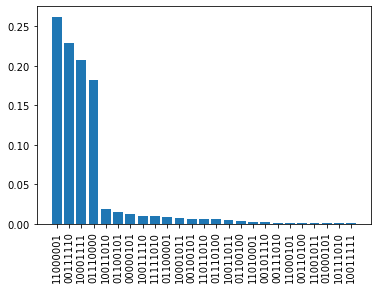

In [4]:
temp=0.3
beta=1./temp
model.run_exact_sampling(beta)# change name of this thing. It does not seem so good at the moment.
## get the distribution from model
bpd = model.boltzmann_pd
## plot the distribution
plot_bargraph_desc_order(bpd, label= 'Boltzmann Dist.', plot_first_few= 25)

# Running  classical mcmc

In [22]:
# 10 seperate chains of classical mcmc for the given problem instance
N_hops=10000;num_seperate_mcmc_chains=4; return_last_n_states=N_hops; initial_state='11000001'
# later get rid of energy difference and hamming distance dicts.
dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc=run_mcmc_different_chains(n_spins, 
N_hops, num_seperate_mcmc_chains,
model, temp=temp,initial_state=initial_state ,return_last_n_states=return_last_n_states,
return_both=True )

  0%|          | 0/4 [00:00<?, ?it/s]

Whether running quantum mcmc: False
starting with:  11000001


 25%|██▌       | 1/4 [00:01<00:05,  1.70s/it]

starting with:  11000001


 50%|█████     | 2/4 [00:02<00:02,  1.33s/it]

starting with:  11000001


 75%|███████▌  | 3/4 [00:03<00:01,  1.21s/it]

starting with:  11000001


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


In [23]:
list_running_js=[]
for i in range(0,num_seperate_mcmc_chains):# need to make this fast! it running very slowly rn
  print("i:",i)
  chain_accepted_state=trajectory_processing(dict_seperate_chains_accepted_mcmc[i])
  running_js=chain_accepted_state.running_js_divergence(model.boltzmann_pd)
  list_running_js.append(running_js)

  0%|          | 0/99 [00:00<?, ?it/s]d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
 32%|███▏      | 32/99 [00:00<00:00, 312.15it/s]

i: 0


 44%|████▍     | 44/99 [00:00<00:00, 213.70it/s]

i: 1


 25%|██▌       | 25/99 [00:00<00:00, 249.68it/s]

i: 2


 28%|██▊       | 28/99 [00:00<00:00, 261.68it/s]

i: 3


100%|██████████| 99/99 [00:00<00:00, 227.90it/s]


In [9]:
def plot_mean_running_avg(list_of_list:list, label:str, start_x_from=0,stepsize:int=100):
  mean_running_val=np.mean(list_of_list,axis=0)
  std=np.std(list_of_list,axis=0)
  #plt.fill_between(range(start_x_from,N_hops,step), mean_running_val+std/2, mean_running_val-std/2, alpha=0.1)
  plt.plot(list(range(start_x_from,N_hops,stepsize)),mean_running_val,"o-",label=label, linewidth=2)

In [51]:
plot_mean_running_avg(np.sqrt(list_running_js),label="cl mcmc",start_x_from=100)
plt.xlabel("mcmc iter");plt.ylabel("JS Distance");plt.legend()

TypeError: plot_mean_running_avg() missing 1 required positional argument: 'N_hops'

In [54]:
# steps = 20000
# # change the naming convention here!
# config_counts_c, proposed_states_c, accepted_states_c =classical_mcmc(
#     N_hops=steps,
#     model=model,
#     initial_state='11000001',# low energy states
#     return_last_n_states=20000,
#     return_additional_lists=True,
#     temp=1/beta,
# )

# # instatiate an object of class "trajectory_processing"
# trajectory_c = trajectory_processing(accepted_states_c)

# Running quantum mcmc

In [52]:
# 10 seperate chains of quantum mcmc for the given problem instance
N_hops_q=1500;num_seperate_mcmc_chains_q=6; return_last_n_states_q=N_hops_q
dict_seperate_chains_states_distn_mcmc_q, dict_seperate_chains_sprime_mcmc_q, dict_seperate_chains_accepted_mcmc_q=run_mcmc_different_chains(n_spins, 
N_hops_q, num_seperate_mcmc_chains_q,
model, temp=temp,initial_state=initial_state ,return_last_n_states=return_last_n_states_q,
return_both=True,is_quantum_mcmc=True, alpha=model.alpha )

  0%|          | 0/6 [00:00<?, ?it/s]

Whether running quantum mcmc: True
starting with:  11000001


 17%|█▋        | 1/6 [05:55<29:38, 355.74s/it]

starting with:  11000001


 33%|███▎      | 2/6 [11:36<23:08, 347.06s/it]

starting with:  11000001


 50%|█████     | 3/6 [17:23<17:21, 347.08s/it]

starting with:  11000001


 67%|██████▋   | 4/6 [23:14<11:36, 348.39s/it]

starting with:  11000001


 83%|████████▎ | 5/6 [29:08<05:50, 350.66s/it]

starting with:  11000001


100%|██████████| 6/6 [34:55<00:00, 349.24s/it]


In [53]:
list_running_js_q=[]
for i in range(0,num_seperate_mcmc_chains_q):# need to make this fast! it running very slowly rn
  print("i:",i)
  chain_accepted_state_q=trajectory_processing(dict_seperate_chains_accepted_mcmc_q[i])
  running_js_q=chain_accepted_state_q.running_js_divergence(model.boltzmann_pd)
  list_running_js_q.append(running_js_q)

  0%|          | 0/14 [00:00<?, ?it/s]d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
  0%|          | 0/14 [00:00<?, ?it/s]

i: 0
i: 1
i: 2
i: 3


100%|██████████| 14/14 [00:00<00:00, 350.05it/s]

i: 4
i: 5


In [43]:
def plot_mean_running_avg(list_of_list:list, label:str,N_hops, start_x_from=0,stepsize:int=100):
  mean_running_val=np.mean(list_of_list,axis=0)
  std=np.std(list_of_list,axis=0)
  #plt.fill_between(range(start_x_from,N_hops,step), mean_running_val+std/2, mean_running_val-std/2, alpha=0.1)
  plt.plot(list(range(start_x_from,N_hops,stepsize)),mean_running_val,"-",label=label, linewidth=2)

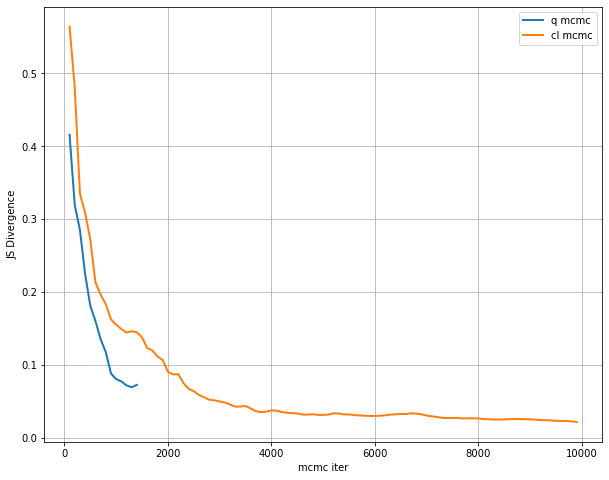

In [58]:
plt.figure(figsize=(10,8))
plot_mean_running_avg(list_running_js_q,label="q mcmc",N_hops=N_hops_q,start_x_from=100)
plot_mean_running_avg(list_running_js[:4],label="cl mcmc",N_hops=N_hops,start_x_from=100)
plt.grid(axis="both")
plt.xlabel("mcmc iter");plt.ylabel("JS Divergence");plt.legend()

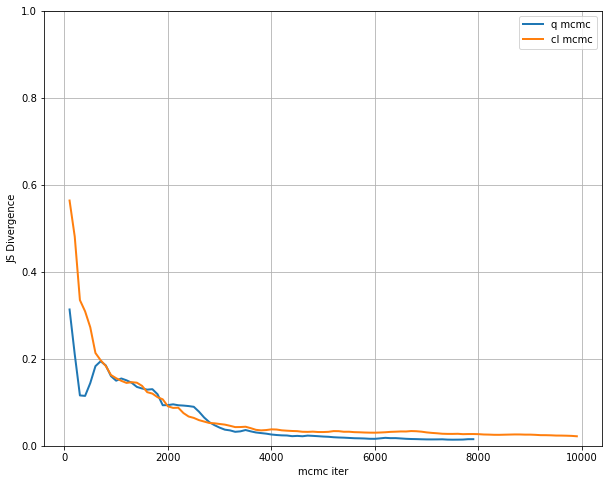

In [48]:
plt.figure(figsize=(10,8))
plot_mean_running_avg(list_running_js_q,label="q mcmc",N_hops=N_hops_q,start_x_from=100)
plot_mean_running_avg(list_running_js[:4],label="cl mcmc",N_hops=N_hops,start_x_from=100)
plt.ylim(0,1); plt.grid(axis="both")
plt.xlabel("mcmc iter");plt.ylabel("JS Divergence");plt.legend()

### ignore whatever is below for the time being

In [55]:
# steps = 8000
# config_counts_q, proposed_states_q, accepted_states_q =quantum_enhanced_mcmc(
#     N_hops=steps,
#     model=model,
#     initial_state='11000001',# low energy states
#     return_last_n_states=8000,
#     return_additional_lists=True,
#     temp=1/beta,
# )

# trajectory_q = trajectory_processing(accepted_states_q)

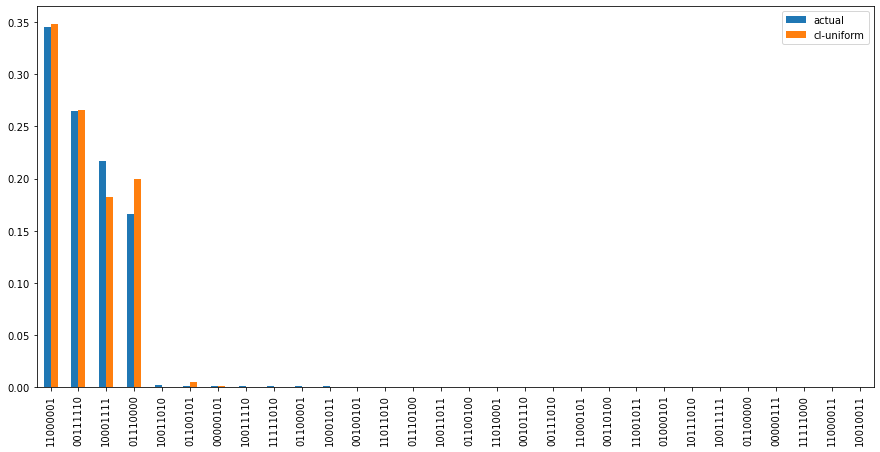

In [16]:
dict_cl=trajectory_processing(accepted_states_c[100:]).empirical_distn()
plot_multiple_bargraphs(list_of_dicts=[bpd,dict_cl],
list_labels=["actual","cl-uniform"],
list_normalise=[False,False],
plot_first_few=30,
sort_desc=True)

In [17]:
dict_q=trajectory_processing(accepted_states_q[100:]).empirical_distn()

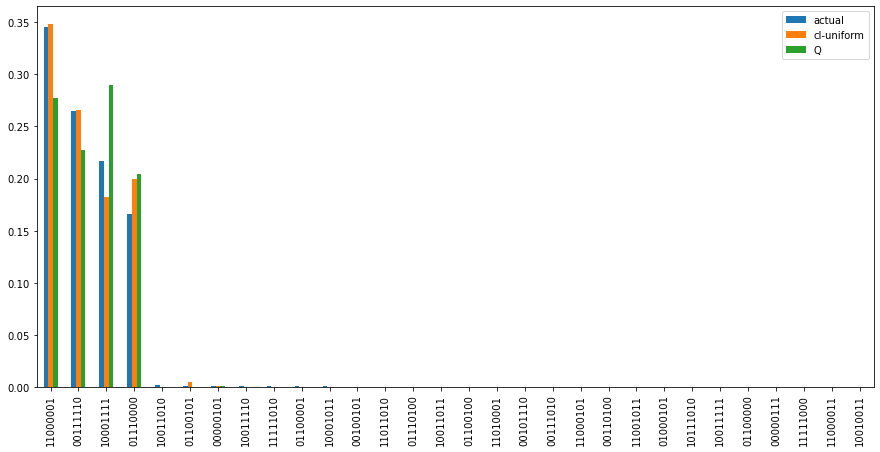

In [18]:
### plot bar graphs here
plot_multiple_bargraphs(list_of_dicts=[bpd,dict_cl,dict_q],
list_labels=["actual","cl-uniform","Q"],
list_normalise=[False,False,False],
plot_first_few=30,
sort_desc=True)

## JS divergence comparison for both classical and quantum case

In [19]:
jsdiv_c=trajectory_c.running_js_divergence(model.boltzmann_pd)
jsdiv_q=trajectory_q.running_js_divergence(model.boltzmann_pd)

  0%|          | 0/199 [00:00<?, ?it/s]d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: divide by zero encountered in log2
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
d:\Desktop\qumcmc_package_test\qumcmc\prob_dist.py:112: RuntimeWarning: invalid value encountered in multiply
  return np.sum(np.where(p_arr>10**-6,p_arr*np.log2(p_arr/q_arr),0.))
100%|██████████| 79/79 [00:00<00:00, 300.77it/s]


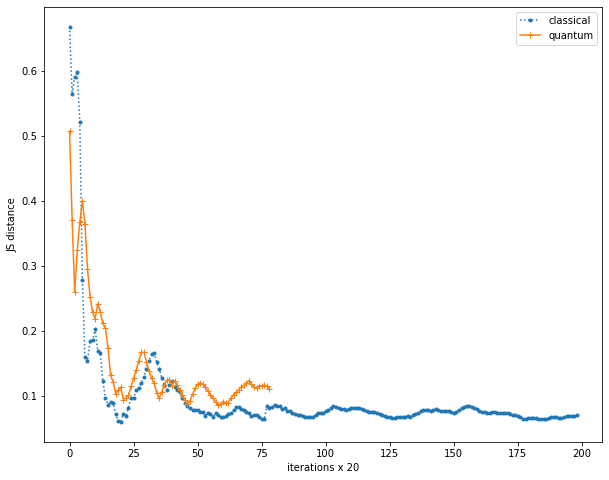

In [21]:
plt.figure(figsize=(10,8))
plt.plot(np.sqrt(jsdiv_c[:8000]),".:" ,label= 'classical')
plt.plot(np.sqrt(jsdiv_q),"+-" ,label= 'quantum')
plt.xlabel("iterations x 20")
plt.ylabel("JS distance")
plt.legend()
plt.show()

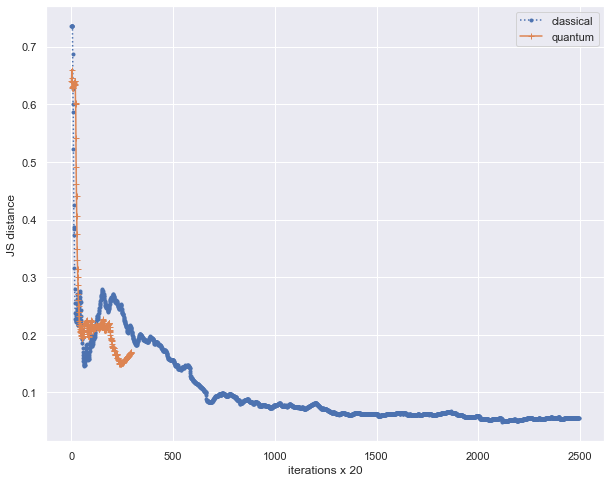

In [144]:
plt.figure(figsize=(10,8))
plt.plot(np.sqrt(jsdiv_c),".:" ,label= 'classical')
plt.plot(np.sqrt(jsdiv_q),"+-" ,label= 'quantum')
plt.xlabel("iterations x 20")
plt.ylabel("JS distance")
plt.legend()
plt.show()